# Convection in 2D cylindrical geometry: Taylor dispersion

*MW, 230830*

## Introduction

This Notebook presents a first finite-volume modelisation of the dispersion of a solute in a fluid in a thin, long cylindrical tube undergoing Poiseuille flow. This dispersion is described, theoretically and experimentally, in the seminal paper by Taylor [1]. Further background can be found in that paper.

In the present Notebook, only the purely convective case is studied. A finite-volume solution of the corresponding partial differential equation is obtained using PyFVTool. This result is compared to the analytic expression obtained by Taylor [1].

## To do

- Add further explanations
- Change Taylor's radial average to a radial integral (or FV radial integral to FV radial average)
- Optimize numerical solution scheme and parameters
- Try and compare different FV discretizations of the convective term?

## References
[1] G. I. Taylor. 'Dispersion of Soluble Matter in Solvent Flowing Slowly through a Tube.', *Proc. Royal Soc. A* **1953**, *219*, 186–203. https://doi.org/10.1098/rspa.1953.0139

## Import modules & define utility functions

In [1]:
import numpy as np
from typing import Any
from numpy.typing import NDArray # type hints need numpy >= 1.21

In [2]:
import matplotlib.pyplot as plt

In [3]:
# enable access to parent directory in order to access pyfvtool module (without pip installation)
from sys import path
path.append('..')

import pyfvtool as pf

In [4]:
# visualization routine (imshow-based)
def phi_visualize():
    print(f't = {t:.1f} s')
    # avoid ghost cells
    plt.imshow(phi.internalCells(), origin = 'lower',
               extent = [zz[0], zz[-1], rr[0]*rzoom, rr[-1]*rzoom])

In [5]:
# calculate simple finite-volume integral over r
def integral_dr(phi0):
    v = pf.cellVolume(phi0.domain).internalCells()
    c = phi0.internalCells()
    return (v*c).sum(axis=0)

### Functions for evaluation of the analytic expression by Taylor ('A3')

In [6]:
# analytic expression from Taylor 1953
def TaylorA3(x: float, t: float, 
             X: float, C_0: float, u_0: float) -> float:
    assert (t >= X/u_0), 't < X/u_0 not implemented'
    if (x >= 0) and (x < X):
        C_m = C_0 * x/(u_0*t)
    elif (x >= X) and (x < u_0*t):
        C_m = C_0 * X/(u_0*t)
    elif (x >= u_0*t) and (x < u_0*t + X):
        C_m = C_0*((X + u_0*t - x)/(u_0*t))
    else:
        C_m = 0.0
    return C_m
           
def TaylorA3_vec(xvec: NDArray[(Any,)], t: float, 
                  X: float, C_0: float, u_0: float) -> NDArray[(Any,)]:
    C_m_vec = np.zeros_like(xvec)
    for ix, x in enumerate(xvec):
        C_m_vec[ix] = TaylorA3(x, t, X, C_0, u_0)
    return C_m_vec  

## Finite-volume scheme with PyFVTool

### Define system & model parameters

In [7]:
Lr = 7.5e-05 # [m] radius of cylinder
Lz = 0.3 # [m] length of cylinder
umax = 2*9.4314e-3 # [m s^-1] max flow velocity = 2 time average flow velocity

In [8]:
# regular grid parameters
Nr = 40
Nz = 500

In [9]:
# initial condition parameters (cell indices)
loadix0 = 20
loadix1 = 40

In [10]:
# timestep parameters
deltat = 0.01 # [s] per time step

In [11]:
# visualization parameters
rzoom = 1000

### PyFVTool finite-volume definition

#### 2D cylindrical mesh

In [12]:
msh = pf.createMeshCylindrical2D(Nr, Nz, Lr, Lz)

#### Set up Poiseuille flow velocity field

In [13]:
rr = msh.cellcenters.x
zz = msh.facecenters.y

In [14]:
uu =  umax*(1 - (rr**2)/(Lr**2)) # does not depend on zz

In [15]:
u =  pf.createFaceVariable(msh, 1.0)

In [16]:
u.xvalue[:] = 0
u.yvalue[:] = uu[:, np.newaxis]

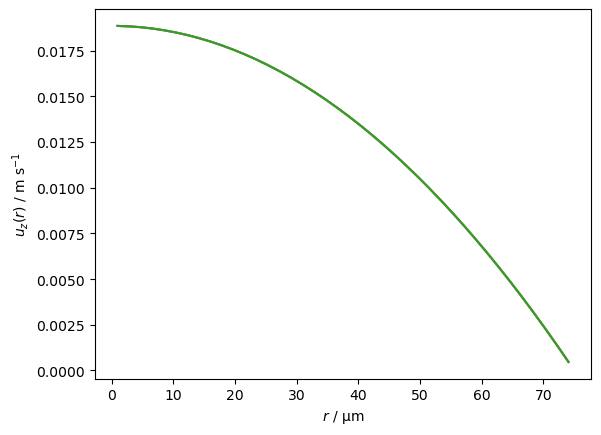

In [17]:
for i in [1, 10, -1]:
    plt.plot(rr*1e6, u.yvalue[:, i])
plt.xlabel('$r$ / µm') 
plt.ylabel('$u_z(r)$ / m s$^{-1}$');

#### Solution variable

In [18]:
bc = pf.createBC(msh)

In [19]:
phi = pf.createCellVariable(msh, 0.0 , bc)

#### Initial condition

In [20]:
t=0.

In [21]:
# initial condition
for i in range(loadix0, loadix1):
    phi.value[:, i] = 1.0

t = 0.0 s


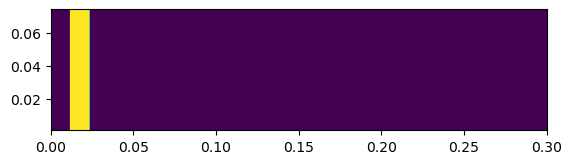

In [22]:
phi_visualize()

In [23]:
initInt = pf.domainInt(phi)
print(initInt)

2.1205750411731096e-10


In [24]:
phiprofs = []
phiprofs.append((t, integral_dr(phi)))

#### Terms with constant matrix contributions

In [25]:
# Mconv = pf.convectionTerm(u) # really ugly?
Mconv = pf.convectionUpwindTerm(u) # numerical diffusion

In [26]:
Mbc, RHSbc = pf.boundaryConditionTerm(bc)

### Solve the convection PDE with time-stepping

In [27]:
for i in range(200):
    # create time-dependent matrix contributions (transientTerm)
    M_trans, RHS_trans = pf.transientTerm(phi, deltat, 1.0)
    M = M_trans + Mbc + Mconv
    RHS = RHS_trans + RHSbc
    phi_new = pf.solvePDE(msh, M, RHS)
    phi.update_value(phi_new)
    t += deltat
phiprofs.append((t, integral_dr(phi)))

In [28]:
print(t, initInt, pf.domainInt(phi), pf.domainInt(phi_new))

2.0000000000000013 2.1205750411731096e-10 2.1205750411730972e-10 2.1205750411730972e-10


t = 2.0 s


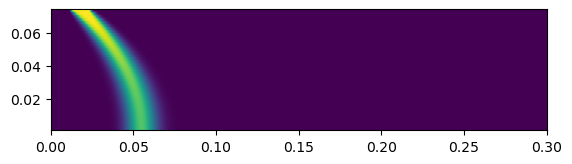

In [29]:
phi_visualize()

In [30]:
for i in range(300):
    # create time-dependent matrix contributions (transientTerm)
    M_trans, RHS_trans = pf.transientTerm(phi, deltat, 1.0)
    M = M_trans + Mbc + Mconv
    RHS = RHS_trans + RHSbc
    phi_new = pf.solvePDE(msh, M, RHS)
    phi.update_value(phi_new)
    t += deltat
phiprofs.append((t, integral_dr(phi)))

In [31]:
for i in range(500):
    # create time-dependent matrix contributions (transientTerm)
    M_trans, RHS_trans = pf.transientTerm(phi, deltat, 1.0)
    M = M_trans + Mbc + Mconv
    RHS = RHS_trans + RHSbc
    phi_new = pf.solvePDE(msh, M, RHS)
    phi.update_value(phi_new)
    t += deltat
phiprofs.append((t, integral_dr(phi)))

In [32]:
print(t, initInt, pf.domainInt(phi), pf.domainInt(phi_new))

9.999999999999831 2.1205750411731096e-10 2.120575041172998e-10 2.120575041172998e-10


t = 10.0 s


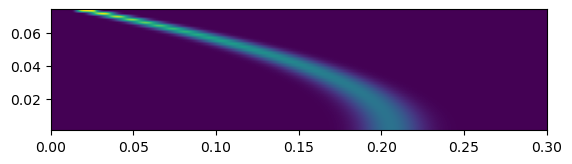

In [33]:
phi_visualize()

## Comparison between the finite-volume result and the analytic solution

Taylor [1] considers the radially averaged concentration profile along the tube as a function of time. We compare that to the radially integrated finite-volume result. (The ratio between the radial integral and radial average is simply constant).

In [34]:
DX = phi.domain.facecenters.y[loadix0]
X = phi.domain.facecenters.y[loadix1] - DX
C_0 = phiprofs[0][1][(loadix0+loadix1)//2] # slot#0 contains initial condition

In [35]:
zzz = np.linspace(0, Lz, 500)

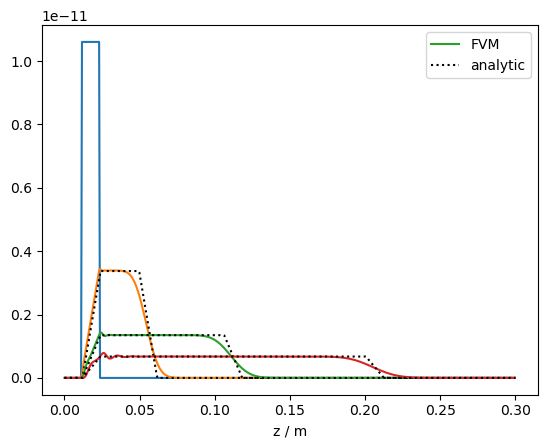

In [36]:
for ix, (tprof, phiprof) in enumerate(phiprofs):
    if ix == 2:
        lbl1 = 'FVM'
        lbl2 = 'analytic'
    else:
        lbl1 = None
        lbl2 = None
    plt.plot(phi.domain.cellcenters.y, phiprof, 
             label=lbl1)
    if tprof >= X/umax:
        plt.plot(zzz, TaylorA3_vec(zzz-DX, tprof, X, C_0, umax),
                 'k:', label=lbl2)
plt.xlabel('z / m')
plt.legend();

The agreement of the finite-volume solution with the analytic result is quite good. The FV calculations parameters have not been optimized. There is some obvious numerical diffusion in the FV result, and also some oscillatory artefact. These numerical artefacts may be reduced by using a different discretization scheme for the convective term. Any good advice in these matters is very welcome!

### Simple quantitative benchmark

In [37]:
(tprof, phiprof) = phiprofs[-1]
z_num, c_num = phi.domain.cellcenters.y, phiprof
c_an_z_num = TaylorA3_vec(z_num-DX, tprof, X, C_0, umax)
norm_err = (c_an_z_num - c_num)/c_an_z_num.max()

(-0.01, 0.01)

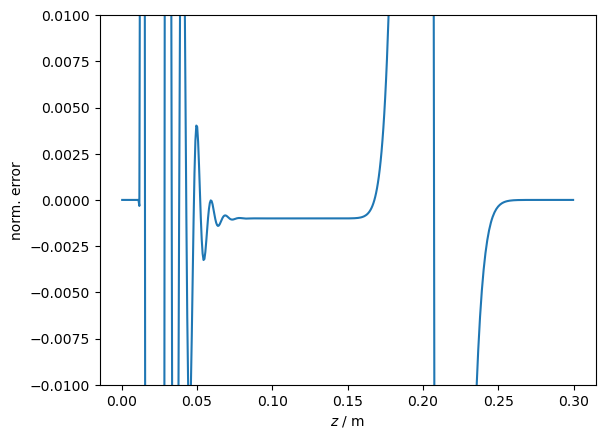

In [38]:
plt.plot(z_num, norm_err)
plt.ylabel('norm. error')
plt.xlabel('$z$ / m');
plt.ylim(-0.01,0.01)

In [39]:
# very basic benchmark for testing integrity of Notebook and calculations
# checks if the normalized error is below a certain threshold (0.15% of max)
# over a range of z (between 1/3 and 1/2 of full scale)
assert np.alltrue(np.abs(norm_err[Nz//3:Nz//2]) < 0.0015), 'benchmark test failed in cylindrical2D_convection'